In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random

In [2]:
import math

class ImagePlot:
    def __init__(self, max_columns=5):
        self.reset()
        self.max_columns = max_columns

    def reset(self):
        self.images = []

    def add(self, image, title=""):
        self.images.append({
            "image": image,
            "title": title
        })

    def show(self):
        n_rows = math.ceil(len(self.images) / self.max_columns)
        n_cols = self.max_columns

        plt.figure(figsize=(25, 7))
        for i in range(len(self.images)):
            plt.subplot(n_rows, n_cols, i+1)
            plt.imshow(self.images[i]["image"], cmap="gray")
            plt.title(self.images[i]["title"])
            plt.axis("off")

        plt.show()

plotter = ImagePlot()

In [3]:
data = scipy.io.loadmat("./data/MNIST.mat")
X = data["X"]
Y = data["I"]

In [4]:
print(X.shape)
print(Y.shape)

(256, 1707)
(1, 1707)


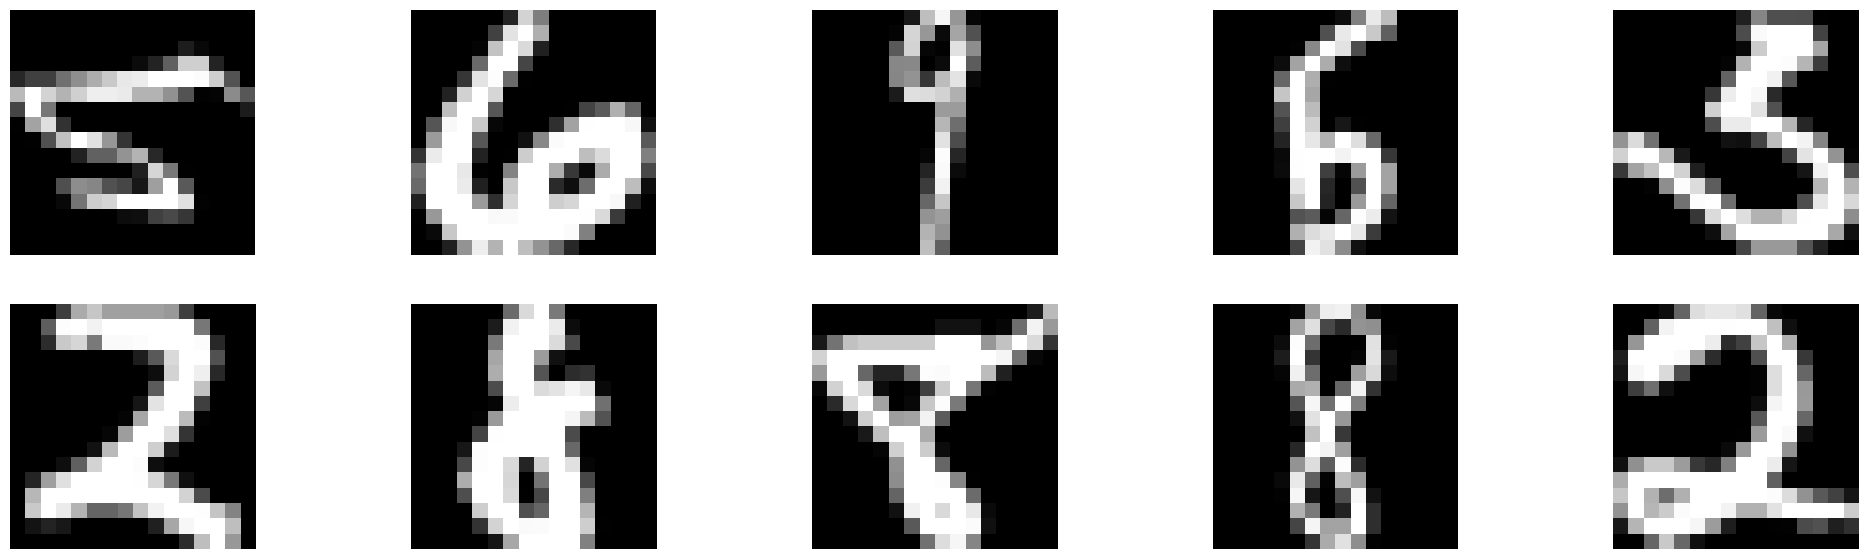

In [5]:
plotter.reset()

for i in [random.randint(0, X.shape[1]) for _ in range(10)]:
    plotter.add(X[:, i].reshape((16, 16)))

plotter.show()

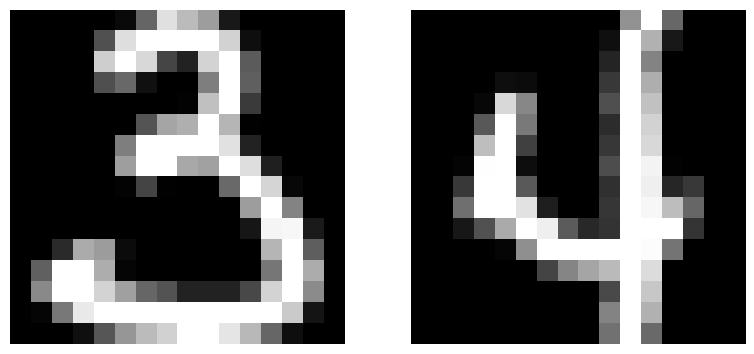

In [6]:
c1 = 3
c2 = 4
X_c1 = X[:, (Y[0] == c1)]
X_c2 = X[:, (Y[0] == c2)]

plotter.reset()
plotter.add(X_c1[:, 0].reshape((16, 16)))
plotter.add(X_c2[:, 0].reshape((16, 16)))
plotter.show()

In [7]:
c1_train_end = int(X_c1.shape[1]*0.8)
X_c1_train = X_c1[:, :c1_train_end]
X_c1_test = X_c1[:, c1_train_end:]

c2_train_end = int(X_c2.shape[1]*0.8)
X_c2_train = X_c2[:, :c2_train_end]
X_c2_test = X_c2[:, c2_train_end:]

print(f"X_c1 | train: {X_c1_train.shape} -- test: {X_c1_test.shape}")
print(f"X_c2 | train: {X_c2_train.shape} -- test: {X_c2_test.shape}")

X_c1 | train: (256, 104) -- test: (256, 27)
X_c2 | train: (256, 97) -- test: (256, 25)


In [8]:
U1, _, _ = np.linalg.svd(X_c1_train, full_matrices=False)
U2, _, _ = np.linalg.svd(X_c2_train, full_matrices=False)

In [9]:
def predict(digit):
    y1_proj = U1 @ (U1.T @ digit)
    y2_proj = U2 @ (U2.T @ digit)

    dist1 = np.linalg.norm(digit - y1_proj, 2)
    dist2 = np.linalg.norm(digit - y2_proj, 2)

    if dist1 < dist2:
        return c1
    else:
        return c2

def evaluate(dataset, true_label):
    correct = 0

    for i in range(dataset.shape[1]):
        if predict(dataset[:, i]) == true_label:
            correct += 1

    return correct

c1_correct = evaluate(X_c1_test, c1)
c2_correct = evaluate(X_c2_test, c2)

print(f"Accuracy: {c1_correct / X_c1_test.shape[1]:.3f} ({X_c1_test.shape[1]-c1_correct}/{X_c1_test.shape[1]} wrong)")
print(f"Accuracy: {c2_correct / X_c2_test.shape[1]:.3f} ({X_c2_test.shape[1]-c2_correct}/{X_c2_test.shape[1]} wrong)")

Accuracy: 1.000 (0/27 wrong)
Accuracy: 1.000 (0/25 wrong)


In [10]:
class MNISTMultiClassPredict:
    def __init__(self):
        self.U_n = {}

    def fit(self, digits_train_set, digits_train_labels):
        for dataset, label in zip(digits_train_set, digits_train_labels):
            U, _, _ = np.linalg.svd(dataset, full_matrices=False)
            self.U_n[label] = U

    def predict(self, digit):
        best_dist = +np.inf
        prediction = None

        for label in self.U_n:
            U = self.U_n[label]
            proj = U @ (U.T @ digit)

            dist = np.linalg.norm(digit - proj, 2)
            if dist < best_dist:
                best_dist = dist
                prediction = label

        return prediction

def evaluate(model, dataset, true_label):
    correct = 0
    for i in range(dataset.shape[1]):
        if model.predict(dataset[:, i]) == true_label:
            correct += 1
    return correct

def generateDataset(digit, train_split=0.8):
    data = X[:, (Y[0] == digit)]
    train_end = int(data.shape[1] * train_split)
    return data[:, :train_end], data[:, train_end:]

In [11]:
to_train_digits = [3, 6, 8, 9]
train_sets = []
test_sets = []

for digit in to_train_digits:
    train, test = generateDataset(digit)
    train_sets.append(train)
    test_sets.append(test)


model = MNISTMultiClassPredict()
model.fit(train_sets, to_train_digits)

In [12]:
for label, test_set in zip(to_train_digits, test_sets):
    correct = evaluate(model, test_set, label)
    print(f"{label} | Accuracy: {correct / test_set.shape[1]:.3f} ({test_set.shape[1]-correct}/{test_set.shape[1]} wrong)")

3 | Accuracy: 0.963 (1/27 wrong)
6 | Accuracy: 1.000 (0/31 wrong)
8 | Accuracy: 0.897 (3/29 wrong)
9 | Accuracy: 1.000 (0/27 wrong)
